In [1]:
import torch

读取数据, 这些是前面保存的数据<br />
orig_boxes: 预测框<br />
orig_scores: 预测框分数(分数越大表示越有可能包含物体而不是背景）<br />
orig_lvl: 层级（FPN提取分层的特征值，这里都是1）<br />

In [2]:
orig_boxes = torch.load('boxes.pt')
orig_scores = torch.load('scores.pt')
orig_lvl = torch.load('lvl.pt')
nms_thresh = 0.7

随机选取50个框

In [3]:
boxes = orig_boxes[1000:1050]
scores = orig_scores[1000:1050]
lvl = orig_lvl[1000:1050]

In [4]:
import cv2

img_path = '2007_000032.jpg'

img = cv2.imread(img_path)
img = cv2.resize(img, (800, 800))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for box in boxes:
    startX, startY, endX, endY = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    cv2.rectangle(img, (startX, startY), (endX, endY), (0, 0, 255), 2)

显示未使用nms前的box

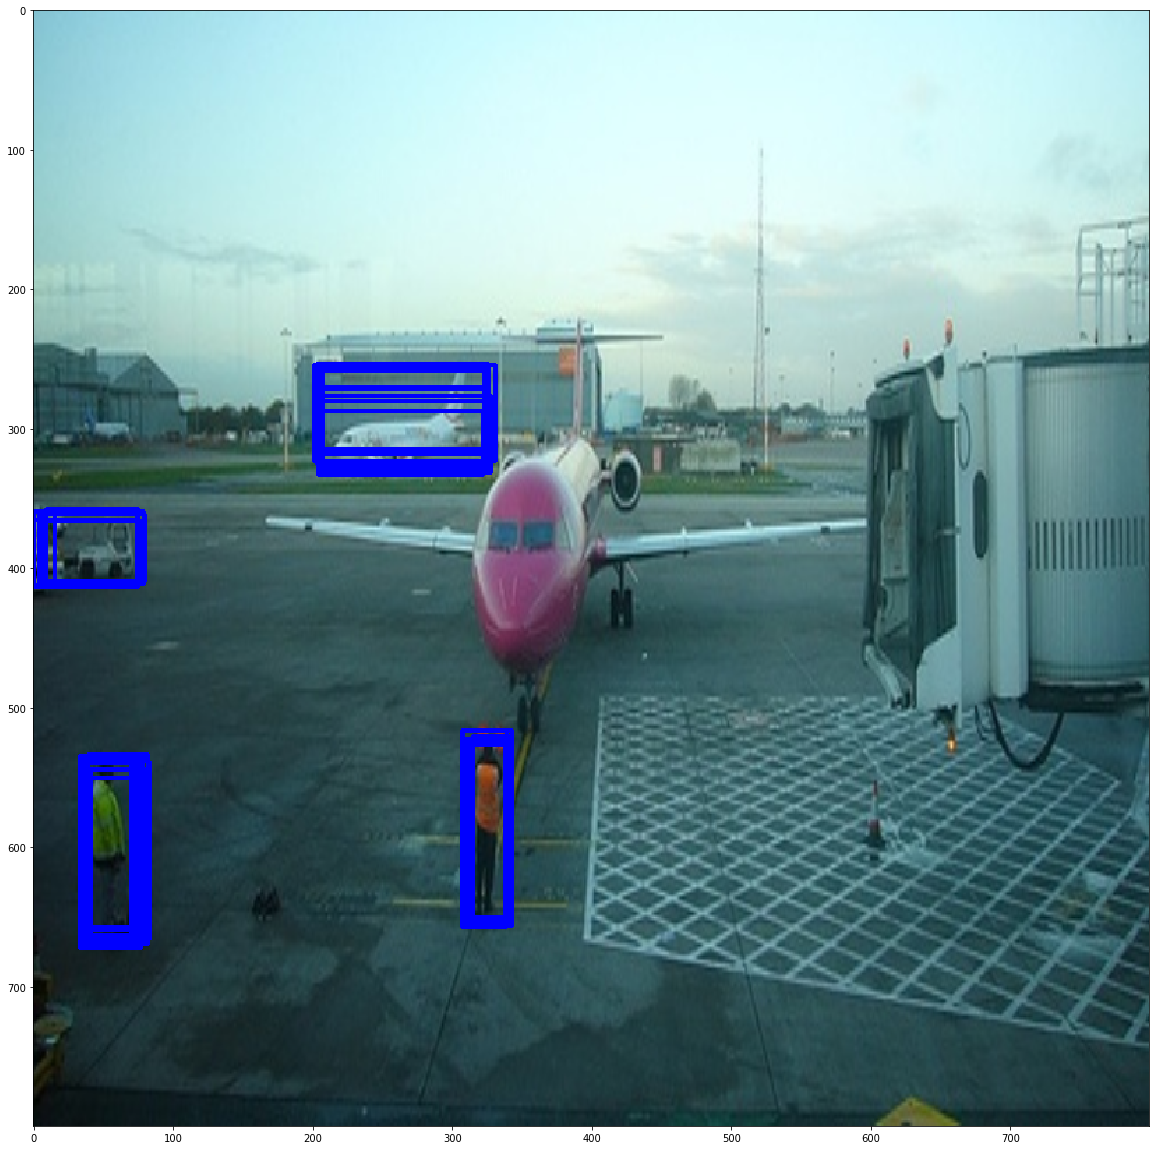

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 30))
plt.imshow(img)

In [8]:
dets = boxes

x1 = dets.select(1, 0).contiguous()
y1 = dets.select(1, 1).contiguous()
x2 = dets.select(1, 2).contiguous()
y2 = dets.select(1, 3).contiguous()

In [9]:
areas = (x2 - x1) * (y2 - y1)

我们根据分数对预测框进行排序，分数高的排在前面

In [10]:
order = scores.sort(0, descending=True)[1]

In [11]:
ndets = dets.size(0)

suppressed标记box是否被过滤掉，1表示被suppress<br />
keep保存需要保留的box

In [12]:
suppressed = torch.zeros(50, dtype=torch.int64)
keep = torch.zeros(50, dtype=torch.int64)

In [13]:
num_to_keep = 0
for _i in range(ndets):
    i = order[_i]
    if suppressed[i] == 1:
        continue
    keep[num_to_keep] = i
    num_to_keep += 1
    ix1 = x1[i]
    iy1 = y1[i]
    ix2 = x2[i]
    iy2 = y2[i]
    iarea = areas[i];
    for _j in range(_i, ndets):
        j = order[_j]
        if suppressed[j] == 1:
              continue
        xx1 = max(ix1, x1[j])
        yy1 = max(iy1, y1[j])
        xx2 = min(ix2, x2[j])
        yy2 = min(iy2, y2[j])
        
        w = max(0, xx2 - xx1)
        h = max(0, yy2 - yy1)
        inter = w * h;
        ovr = inter / (iarea + areas[j] - inter);
        if (ovr > nms_thresh):
            suppressed[j] = 1
    
    

In [14]:
keep.narrow(0, 0, num_to_keep)

tensor([ 0,  1, 10, 18, 30])

In [15]:
after_nms_img = cv2.imread(img_path)
after_nms_img = cv2.resize(after_nms_img, (800, 800))
after_nms_img = cv2.cvtColor(after_nms_img, cv2.COLOR_BGR2RGB)

for i in keep:
    box = boxes[int(i)]
    startX, startY, endX, endY = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    cv2.rectangle(after_nms_img, (startX, startY), (endX, endY), (0, 0, 255), 2)

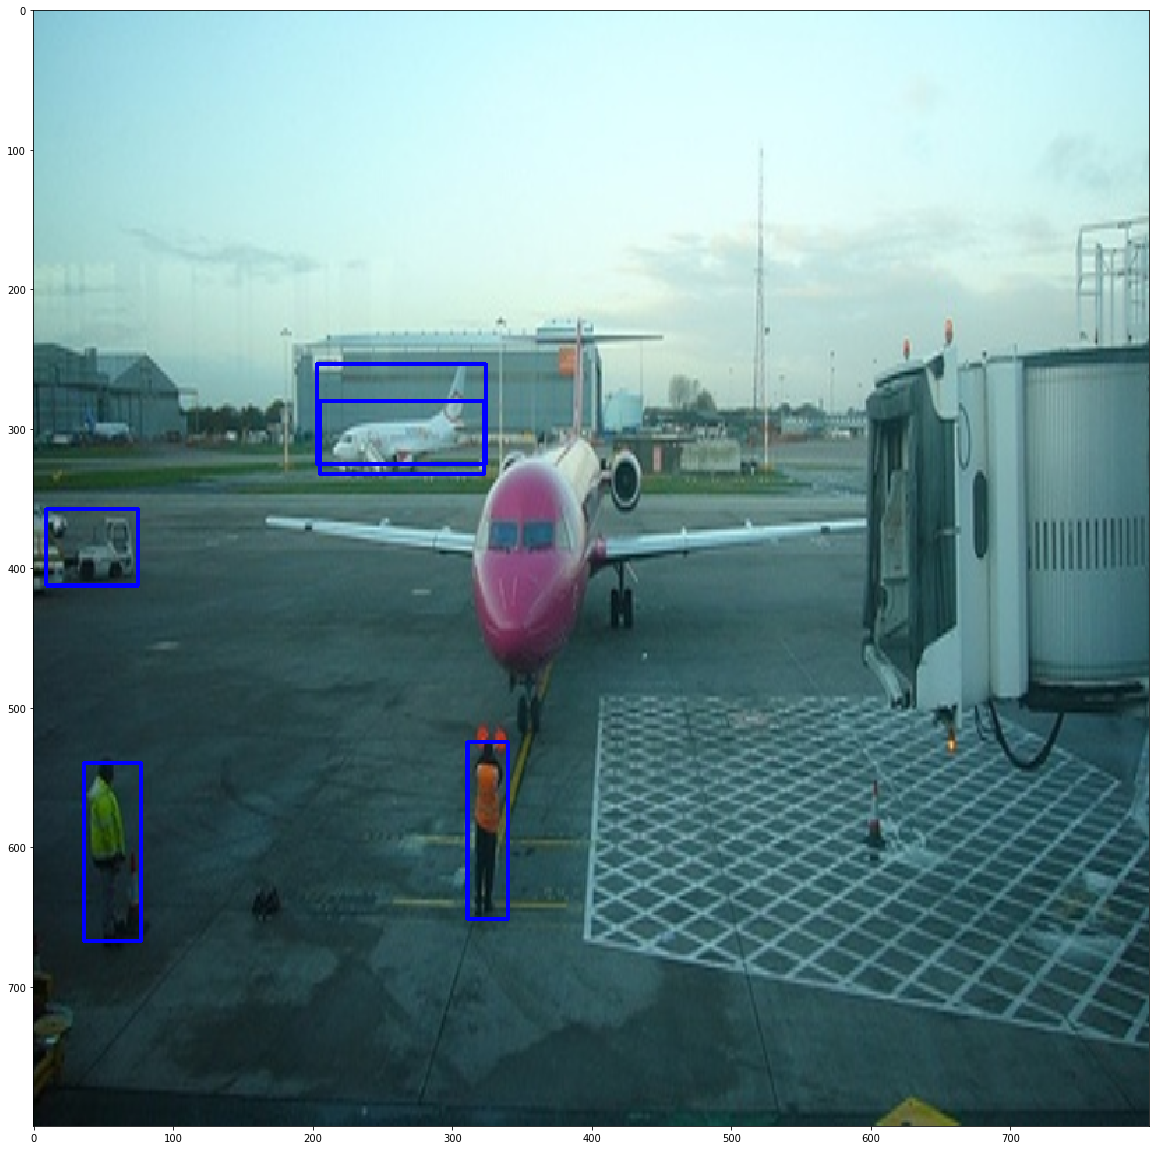

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 30))
plt.imshow(after_nms_img)